## UNZIPPING DATA

In [100]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
!unzip lfw_funneled.zip

Archive:  lfw_funneled.zip
replace lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

2023-03-15 07:41:33.124762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 07:41:33.124874: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 07:41:36.291022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-15 07:41:36.291339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-15 07:41:36.291362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

**LOADING MTCNN MODEL**

In [103]:
detector = mtcnn.MTCNN()

LOADING DATA AND EXTRACTING FACE FROM THE PICTURE

In [104]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/lfw_funneled/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        Result_Training.append(filename.split("_")[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(img)
        x1, y1, h, w = result[0]["box"]
        x2, y2 = x1 + w, y1 + h
        face = img[y1:y2, x1:x2]
        print("Face Dimentions: ", face.shape)
        img = cv2.resize(face, (128, 128))
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

1/1 [==============================] - 0s 139ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
Face Dimentions:  (91, 126, 3)
1/1 [==============================] - 0s 26ms/step
Face Dimentions:  (96, 137, 3)
1/1 [==============================] - 0s 22ms/step
Face Dimentions:  (94, 141, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (96, 131, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (99, 136, 3)
1/1 [==============================] - 0s 18ms/step
Face Dimentions:  (92, 140, 3)
1/1 [==============================] - 0s 23ms/step
Face Dimentions:  (95, 136, 3)
1/1 [==============================] - 0s 27ms/step
Face Dimentions:  (94, 124, 3)
1/1 [==============================] - 0s 29ms/step
Face Dimentions:  (96, 131, 3)
1/1 [==============================] - 0s 28ms/step
Face Dimentions:  (92, 127, 3)
1/1 [==============================] - 0s 22ms/step
Face Dimentions:  (100, 142, 3)
1/1 [==============================

((621, 128, 128, 3), (621,))

# DATA PREPROCESSING

In [105]:
Result = Result_Training
np.array(Result).shape

(621,)

In [106]:
lb = LabelEncoder()
Result = lb.fit_transform(Result)

In [107]:
Temp = []
for i in Result:
    temp = []
    temp.append(i)
    Temp.append(temp)
output_matrix = to_categorical(Temp)
total = output_matrix.shape[1]
output_matrix.shape

(621, 48)

FUCTIONS FOR PSNR AND SSIM

In [108]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

In [109]:
def SSIMS(original, compressed):
  return round(ssim(original, compressed, multichannel=True), 2)

In [110]:
def Print_ALL(original, compressed):
  print("PSRN: ", PSNR(original, compressed))
  print("SSIM: ", SSIMS(original, compressed))

In [111]:
def Print_data(y_real, y_pre):
  cm = confusion_matrix(y_real, y_pre)
  for c in range(27):
      tp = cm[c,c]
      fp = sum(cm[:,c]) - cm[c,c]
      fn = sum(cm[c,:]) - cm[c,c]
      tn = sum(np.delete(sum(cm)-cm[c,:],c))

      recall = tp/(tp+fn)
      precision = tp/(tp+fp)
      specificity = tn/(tn+fp)
      f1_score = 2*((precision*recall)/(precision+recall))
      

      #print(f"for class {c}: acc {accuracy}, recall {recall},\
      #      precision {precision}, f1 {f1_score}")
      print("for class {}: recall {}, specificity {}\
            precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

DOWNSAMPLING CODE FOR IMAGES TO CONVERT THEM TO LR

In [112]:
def down_sampling(ar, fact):
    res = ar[::fact, ::fact, :]
    return res

In [113]:
LR = []
for i in tqdm(range(len(Training)),desc="CONVERTING"):
  LR.append(down_sampling(Training[i], 4))
np.array(LR).shape

CONVERTING: 100%|██████████| 621/621 [00:00<00:00, 399304.43it/s]


(621, 32, 32, 3)

TRUTH GROUND IMAGES AND LR IMAGES

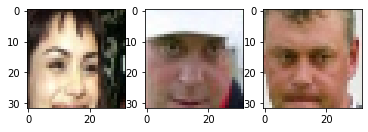

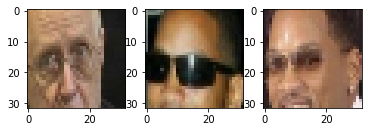

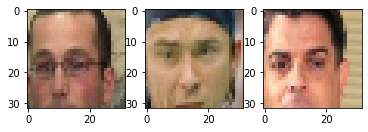

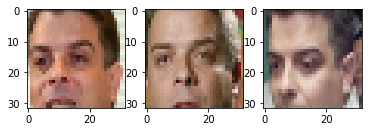

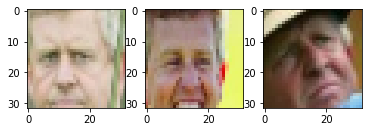

In [114]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(LR[i])
    plt.sca(axarr[1]); 
    plt.imshow(LR[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(LR[i+2])
    plt.show()

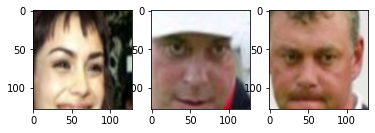

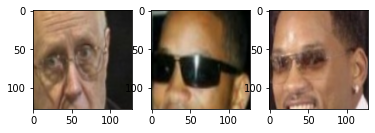

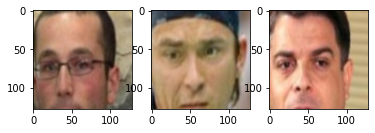

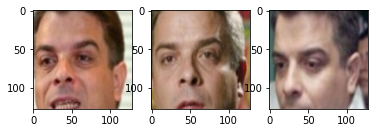

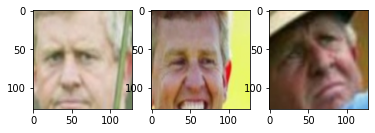

In [115]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Training[i])
    plt.sca(axarr[1]); 
    plt.imshow(Training[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Training[i+2])
    plt.show()

# LAPSRN

In [116]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

In [117]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:51<00:00, 12.17it/s]


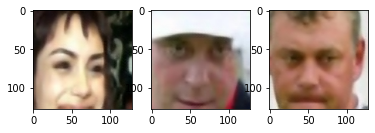

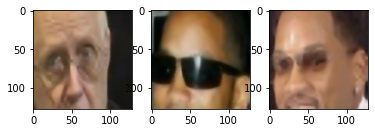

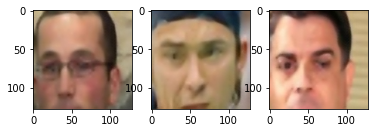

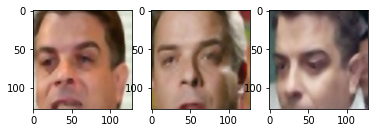

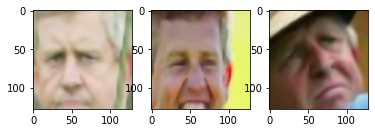

In [118]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULT OF UPSAMPLING**

In [119]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.14
SSIM:  0.94


**TAINING AND TESTING DATA**

In [120]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [121]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [122]:
resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_27 (Dense)            (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [123]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 151ms/step - loss: 5.6585 - accuracy: 0.2634 - precision_6: 0.3138 - recall_6: 0.2016 - val_loss: 3.2158 - val_accuracy: 0.4516 - val_precision_6: 0.6429 - val_recall_6: 0.4355
Epoch 2/10
12/12 [==============================] - 1s 49ms/step - loss: 1.7737 - accuracy: 0.6613 - precision_6: 0.8430 - recall_6: 0.5054 - val_loss: 2.6200 - val_accuracy: 0.4839 - val_precision_6: 0.6901 - val_recall_6: 0.3952
Epoch 3/10
12/12 [==============================] - 1s 50ms/step - loss: 0.9592 - accuracy: 0.7957 - precision_6: 0.9176 - recall_6: 0.6882 - val_loss: 2.1395 - val_accuracy: 0.5645 - val_precision_6: 0.8194 - val_recall_6: 0.4758
Epoch 4/10
12/12 [==============================] - 1s 54ms/step - loss: 0.4671 - accuracy: 0.9086 - precision_6: 0.9654 - recall_6: 0.8253 - val_loss: 2.2615 - val_accuracy: 0.5565 - val_precision_6: 0.6744 - val_recall_6: 0.4677
Epoch 5/10
12/12 [==============================] - 1s 55ms/step - loss: 0.

# IMPORTANT PLOTS

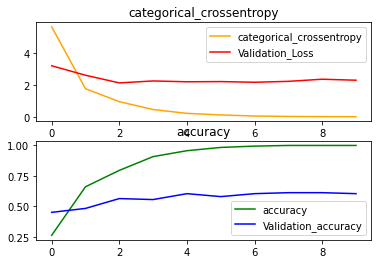

In [124]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

KeyError: ignored

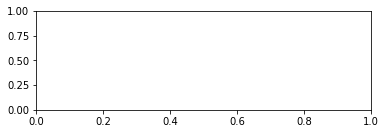

In [125]:
plt.subplot(2,1,1)
plt.plot(history.history["precision"], color='orange')
plt.plot(history.history["val_precision"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall"], color='green')
plt.plot(history.history["val_recall"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

# ANSWERS

In [126]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 48ms/step - loss: 1.9569 - accuracy: 0.6880 - precision_6: 0.7568 - recall_6: 0.6720
ACCURACY:  0.69
LOSS:  1.96
Precision:  0.76
Recall:  0.67


In [127]:
pre = resnet_model.predict(Temp_Train)

4/4 [==============================] - 1s 43ms/step


In [128]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

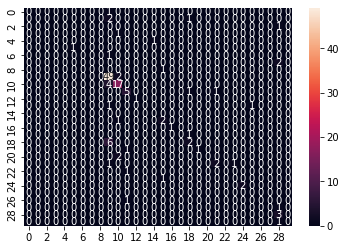

In [129]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [130]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.9608, specificity 0.7838            precision 0.7538, f1 0.8448
for class 10: recall 0.8095, specificity 0.9423            precision 0.7391, f1 0.7727
for class 11: recall 0.7143, specificity 0.9746            precision 0.625, f1 0.6667
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0


<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:9: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))


# MOBILENETv2

In [7]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=48,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(48, activation='softmax'))

In [8]:
mobile_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              2623488   
                                                                 
 dense_3 (Dense)             (None, 48)                98352     
                                                                 
Total params: 4,979,824
Trainable params: 2,721,840
Non-trainable params: 2,257,984
_________________________________________________________________


In [132]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 133ms/step - loss: 3.4423 - accuracy: 0.3226 - precision_7: 0.3819 - recall_7: 0.1478 - val_loss: 3.4305 - val_accuracy: 0.1532 - val_precision_7: 0.2000 - val_recall_7: 0.0887
Epoch 2/10
12/12 [==============================] - 0s 39ms/step - loss: 2.4463 - accuracy: 0.3710 - precision_7: 0.4692 - recall_7: 0.1640 - val_loss: 2.9552 - val_accuracy: 0.3790 - val_precision_7: 0.5179 - val_recall_7: 0.2339
Epoch 3/10
12/12 [==============================] - 0s 29ms/step - loss: 2.0904 - accuracy: 0.4274 - precision_7: 0.6602 - recall_7: 0.1828 - val_loss: 2.8067 - val_accuracy: 0.3548 - val_precision_7: 0.5172 - val_recall_7: 0.1210
Epoch 4/10
12/12 [==============================] - 0s 30ms/step - loss: 1.8216 - accuracy: 0.4973 - precision_7: 0.7566 - recall_7: 0.3091 - val_loss: 2.7237 - val_accuracy: 0.3871 - val_precision_7: 0.6585 - val_recall_7: 0.2177
Epoch 5/10
12/12 [==============================] - 0s 36ms/step - loss: 1.

**Graphs**

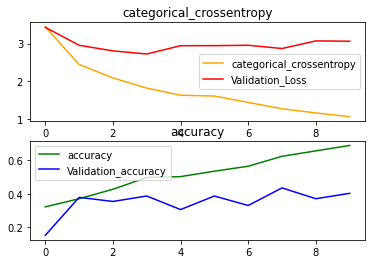

In [133]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_1"], color='orange')
plt.plot(history.history["val_precision_1"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_1"], color='green')
plt.plot(history.history["val_recall_1"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [134]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 17ms/step - loss: 2.5696 - accuracy: 0.5120 - precision_7: 0.5795 - recall_7: 0.4080
ACCURACY:  0.51
LOSS:  2.57
Precision:  0.58
Recall:  0.41


In [135]:
pre = mobile_model.predict(Temp_Train)

4/4 [==============================] - 1s 12ms/step


In [136]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

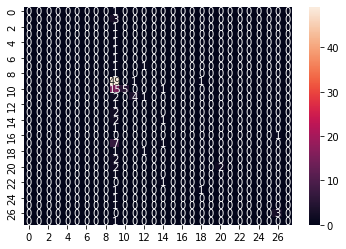

In [137]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [138]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.9608, specificity 0.3108            precision 0.49, f1 0.649
for class 10: recall 0.2381, specificity 1.0            precision 1.0, f1 0.3846
for class 11: recall 0.5714, specificity 0.9915            precision 0.8, f1 0.6667
for class 12: recall 0.0, specificity 0.9758            precision 0.0, f1 nan
for clas

<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))


# EDSR MODEL

In [139]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x4.pb')
super_res.setModel('edsr',4)

In [140]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [12:53<00:00,  1.24s/it]


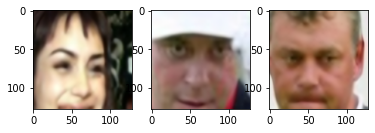

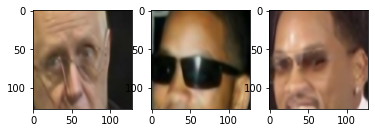

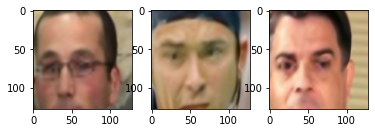

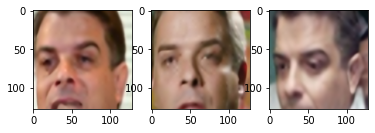

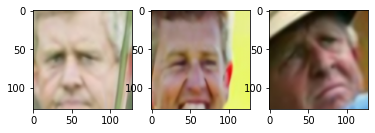

In [141]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**Comapring The SR result**

In [142]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.17
SSIM:  0.94


**TESTING AND TRAINING**

In [143]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Temp_Train), np.array(output_matrix), shuffle=True, random_state=128, train_size=.80)
X_train.shape, X_test.shape 

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [144]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [145]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_31 (Dense)            (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [146]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 6s 249ms/step - loss: 6.0907 - accuracy: 0.3038 - precision_8: 0.4095 - recall_8: 0.2554 - val_loss: 4.1251 - val_accuracy: 0.2903 - val_precision_8: 0.3068 - val_recall_8: 0.2177
Epoch 2/10
12/12 [==============================] - 1s 70ms/step - loss: 2.1880 - accuracy: 0.5161 - precision_8: 0.5833 - recall_8: 0.3575 - val_loss: 2.3700 - val_accuracy: 0.4274 - val_precision_8: 0.6620 - val_recall_8: 0.3790
Epoch 3/10
12/12 [==============================] - 1s 57ms/step - loss: 1.1265 - accuracy: 0.6828 - precision_8: 0.8062 - recall_8: 0.5591 - val_loss: 2.1827 - val_accuracy: 0.5081 - val_precision_8: 0.7231 - val_recall_8: 0.3790
Epoch 4/10
12/12 [==============================] - 1s 54ms/step - loss: 0.5364 - accuracy: 0.8710 - precision_8: 0.9595 - recall_8: 0.7634 - val_loss: 2.1095 - val_accuracy: 0.5726 - val_precision_8: 0.7750 - val_recall_8: 0.5000
Epoch 5/10
12/12 [==============================] - 1s 51ms/step - loss: 0.

**graphs**

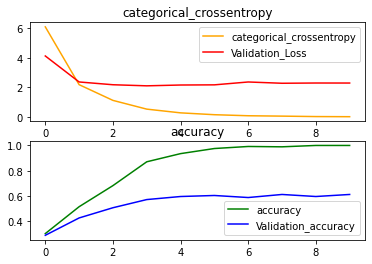

In [147]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_2"], color='orange')
plt.plot(history.history["val_precision_2"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_2"], color='green')
plt.plot(history.history["val_recall_2"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answer**

In [148]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 37ms/step - loss: 1.9855 - accuracy: 0.7120 - precision_8: 0.7963 - recall_8: 0.6880
ACCURACY:  0.71
LOSS:  1.99
Precision:  0.8
Recall:  0.69


In [149]:
pre = resnet_model.predict(X_test)

4/4 [==============================] - 1s 40ms/step


In [150]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

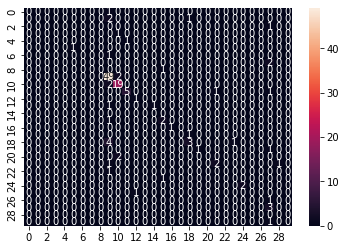

In [151]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [152]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.9608, specificity 0.8108            precision 0.7778, f1 0.8596
for class 10: recall 0.9048, specificity 0.9519            precision 0.7917, f1 0.8444
for class 11: recall 0.7143, specificity 0.9915            precision 0.8333, f1 0.7692
for class 12: recall 1.0, specificity 0.9919            precision 0.5, f1 

<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:9: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))


# MOBILENETv2

In [153]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [154]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 117ms/step - loss: 4.0140 - accuracy: 0.2473 - precision_9: 0.3228 - recall_9: 0.1371 - val_loss: 3.1033 - val_accuracy: 0.2823 - val_precision_9: 0.2955 - val_recall_9: 0.1048
Epoch 2/10
12/12 [==============================] - 0s 25ms/step - loss: 2.5172 - accuracy: 0.4032 - precision_9: 0.4892 - recall_9: 0.1828 - val_loss: 2.6840 - val_accuracy: 0.3952 - val_precision_9: 0.6552 - val_recall_9: 0.1532
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 1.9536 - accuracy: 0.4946 - precision_9: 0.8283 - recall_9: 0.2204 - val_loss: 2.8048 - val_accuracy: 0.3710 - val_precision_9: 0.7000 - val_recall_9: 0.1694
Epoch 4/10
12/12 [==============================] - 0s 24ms/step - loss: 1.7824 - accuracy: 0.5376 - precision_9: 0.7857 - recall_9: 0.2957 - val_loss: 2.8395 - val_accuracy: 0.3226 - val_precision_9: 0.6047 - val_recall_9: 0.2097
Epoch 5/10
12/12 [==============================] - 0s 24ms/step - loss: 1.

**Graphs**

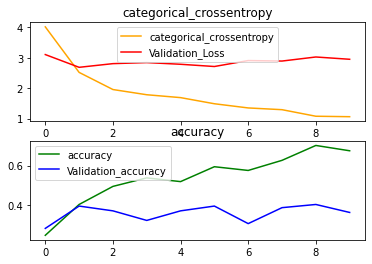

In [155]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_3"], color='orange')
plt.plot(history.history["val_precision_3"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_3"], color='green')
plt.plot(history.history["val_recall_3"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**ANSWERS**

In [156]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 17ms/step - loss: 2.6640 - accuracy: 0.4560 - precision_9: 0.6585 - recall_9: 0.2160
ACCURACY:  0.46
LOSS:  2.66
Precision:  0.66
Recall:  0.22


In [157]:
pre = mobile_model.predict(X_test)

4/4 [==============================] - 1s 16ms/step


In [158]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

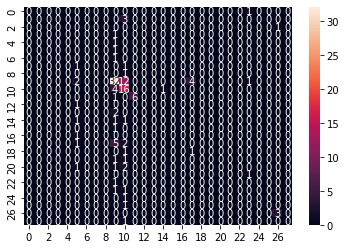

In [159]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [160]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 0.0, specificity 0.9355            precision 0.0, f1 nan
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.6275, specificity 0.7027            precision 0.5926, f1 0.6095
for class 10: recall 0.7619, specificity 0.7308            precision 0.3636, f1 0.4923
for class 11: recall 0.8571, specificity 1.0            precision 1.0, f1 0.9231
for class 12: recall 0.0, specificity 1.0            precision nan, f1 nan
fo

<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))


# BICUBIC MODEL

In [161]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = cv2.resize(LR[i], (128, 128), interpolation=cv2.INTER_CUBIC)
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:00<00:00, 3937.52it/s]


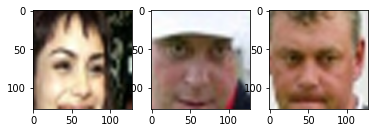

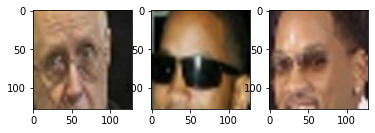

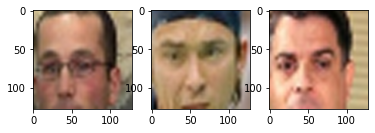

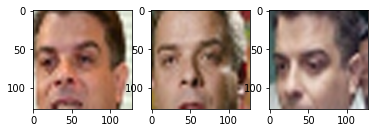

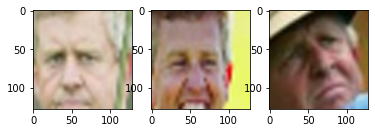

In [162]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULTS**

In [163]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.01
SSIM:  0.94


In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Temp_Train), np.array(output_matrix), shuffle=True, random_state=128, train_size=.80)
X_train.shape, X_test.shape 

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [165]:
resnet_model = Sequential()
pretrained_mRESULTSodel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [166]:
resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_14 (Flatten)        (None, 1280)              0         
                                                                 
 dense_34 (Dense)            (None, 2048)              2623488   
                                                                 
 dense_35 (Dense)            (None, 48)                98352     
                                                                 
Total params: 4,979,824
Trainable params: 2,721,840
Non-trainable params: 2,257,984
_________________________________________________________________


In [167]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 114ms/step - loss: 3.9269 - accuracy: 0.2473 - precision_10: 0.2767 - recall_10: 0.1183 - val_loss: 2.9116 - val_accuracy: 0.2500 - val_precision_10: 0.3571 - val_recall_10: 0.0806
Epoch 2/10
12/12 [==============================] - 0s 27ms/step - loss: 2.2707 - accuracy: 0.4435 - precision_10: 0.6364 - recall_10: 0.1882 - val_loss: 2.6293 - val_accuracy: 0.4113 - val_precision_10: 0.5283 - val_recall_10: 0.2258
Epoch 3/10
12/12 [==============================] - 0s 24ms/step - loss: 1.8901 - accuracy: 0.5269 - precision_10: 0.7125 - recall_10: 0.3065 - val_loss: 2.6790 - val_accuracy: 0.3790 - val_precision_10: 0.5500 - val_recall_10: 0.0887
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 1.6522 - accuracy: 0.5672 - precision_10: 0.8041 - recall_10: 0.3199 - val_loss: 2.6557 - val_accuracy: 0.4355 - val_precision_10: 0.6364 - val_recall_10: 0.2258
Epoch 5/10
12/12 [==============================] - 0s 25ms

**Graphs**

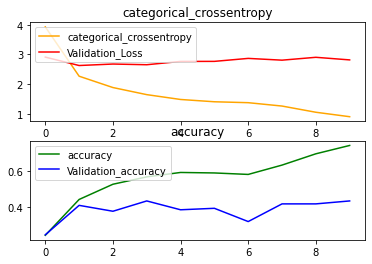

In [168]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_4"], color='orange')
plt.plot(history.history["val_precision_4"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_4"], color='green')
plt.plot(history.history["val_recall_4"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [169]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 17ms/step - loss: 2.5960 - accuracy: 0.4960 - precision_10: 0.6087 - recall_10: 0.3360
ACCURACY:  0.5
LOSS:  2.6
Precision:  0.61
Recall:  0.34


In [170]:
pre = resnet_model.predict(X_test)

4/4 [==============================] - 1s 16ms/step


In [171]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

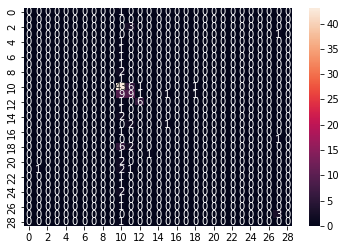

In [172]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [173]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall nan, specificity 0.992            precision 0.0, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 10: recall 0.8431, specificity 0.4595            precision 0.5181, f1 0.6418
for class 11: recall 0.4286, specificity 0.8654            precision 0.3913, f1 0.4091
for class 12: recall 0.8571, specificity 0.9831            precision 0.75, f1 0.8
fo

<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:9: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))


# MOBILENETv2

In [174]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [175]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 113ms/step - loss: 3.7033 - accuracy: 0.2661 - precision_11: 0.2925 - recall_11: 0.1156 - val_loss: 2.9134 - val_accuracy: 0.3790 - val_precision_11: 0.4571 - val_recall_11: 0.2581
Epoch 2/10
12/12 [==============================] - 0s 28ms/step - loss: 2.1751 - accuracy: 0.4839 - precision_11: 0.6496 - recall_11: 0.2392 - val_loss: 2.8305 - val_accuracy: 0.3306 - val_precision_11: 0.4545 - val_recall_11: 0.0806
Epoch 3/10
12/12 [==============================] - 0s 24ms/step - loss: 1.8357 - accuracy: 0.5161 - precision_11: 0.7231 - recall_11: 0.2527 - val_loss: 2.6535 - val_accuracy: 0.4032 - val_precision_11: 0.5614 - val_recall_11: 0.2581
Epoch 4/10
12/12 [==============================] - 0s 24ms/step - loss: 1.6296 - accuracy: 0.5457 - precision_11: 0.7742 - recall_11: 0.3226 - val_loss: 2.8174 - val_accuracy: 0.4032 - val_precision_11: 0.6122 - val_recall_11: 0.2419
Epoch 5/10
12/12 [==============================] - 0s 23ms

**graphs**

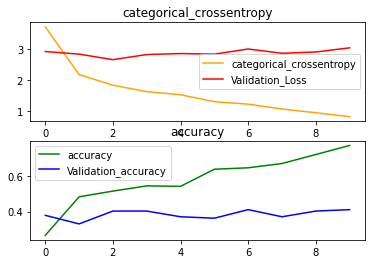

In [176]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_5"], color='orange')
plt.plot(history.history["val_precision_5"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_5"], color='green')
plt.plot(history.history["val_recall_5"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [177]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 16ms/step - loss: 2.6567 - accuracy: 0.5280 - precision_11: 0.5730 - recall_11: 0.4080
ACCURACY:  0.53
LOSS:  2.66
Precision:  0.57
Recall:  0.41


In [178]:
pre = mobile_model.predict(X_test)

4/4 [==============================] - 1s 16ms/step


In [179]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

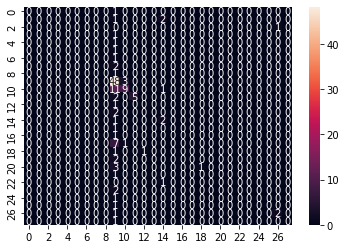

In [180]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [181]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 5: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 8: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 9: recall 0.9412, specificity 0.3514            precision 0.5, f1 0.6531
for class 10: recall 0.4286, specificity 0.9615            precision 0.6923, f1 0.5294
for class 11: recall 0.7143, specificity 1.0            precision 1.0, f1 0.8333
for class 12: recall 0.0, specificity 0.9919            precision 0.0, f1 nan
for c

<ipython-input-111-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-111-fd9aa6c65bf5>:12: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*((precision*recall)/(precision+recall))
